https://www.learnopencv.com/histogram-of-oriented-gradients/

# 1. Giới thiệu về thuật toán HOG

HOG (histogram of oriented gradient) là bộ mô tả đặc trưng (feature descriptor) được sử dụng phổ biến trong computer vision và xử lý ảnh nhằm mục đích **phát hiện vật thể** (object detection). Thuật toán hoạt động dựa trên việc thống kê phân phối histogram của độ lớn gradient (gradient magnitute) theo các nhóm bins là phương gradient (gradient orientation) trên các vùng cục bộ (local portion) của hình ảnh. HOG được tính toán trên một lưới ô vuông được tạo ra trên hình ảnh và sử dụng các chuẩn hóa cục bộ (local normalization) để cải thiện độ chính xác của việc phát hiện vật thể. 

Một số ứng dụng của thuật toán:

Thuật toán HOG được ứng dụng trong nhiều tác vụ khác nhau của thị giác máy tính và mang lại độ chính xác cao. 

* **Nhận diện người (human detection)**: Trước kỉ nguyên bùng nổ của deep learning. Để nhận diện người trong một hình ảnh, chúng ta thường sử dụng thuật toán HOG. Lần đầu tiên ứng dụng này được giới thiệu trong bài báo [Histograms of Oriented Gradients for Human Detection](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) của Dalal và Trigg. HOG có thể phát hiện được một hoặc nhiều người đi bộ trên cùng một hình ảnh. 

![](https://www.pyimagesearch.com/wp-content/uploads/2015/11/pedestrian_detection_person_293.jpg)

Trong phần thực hành chúng ta sẽ xây dựng một thuật toán HOG ứng dụng để phát hiện người đi bộ trong các bức ảnh.

* **Nhận diện khuôn mặt (face detection)**:, chúng ta thường nghĩ ngay đến thuật toán Haar Cascde Classifier. Bên cạnh đó HOG cũng là một thuật toán rất hiệu quả được áp dụng trong bài toán này. Bởi nó có khả năng biểu diễn các đường nét chính của khuôn mặt dựa trên phương và độ lớn gradient thông qua các véc tơ trên mỗi cell như hình mô tả bên dưới:

![](https://miro.medium.com/max/2160/1*gWeh90aKfv7A-bpc0vC0oQ.png)

* **Nhận diện các vật thể khác**: Ngoài ra còn rất nhiều các trường hợp nhận diện vật thể trên ảnh tĩnh chẳng hạn như phương tiện, tín hiệu giao thông, động vật.

Các thuật ngữ sử dụng trong bài:

* **Feature Descriptor**: Bộ mô tả đặc trưng, là kết quả của một phép biến đổi input thông qua một phương pháp biến đổi nào đó như HOG để nhằm tạo ra feature.

* **histogram**: Là biểu đồ histogram biểu diễn phân phối của các cường độ màu sắc theo khoảng giá trị.

* **Gradient**: Là đạo hàm của cường độ màu sắc giúp phát hiện hướng di chuyển của các vật thể trong hình ảnh.

* **Local cell**: Các ô cục bộ. Trong thuật toán HOG, mộ hình ảnh được chia thành nhiều cell bởi một lưới ô vuông. Mỗi cell được gọi là một ô cục bộ.

* **Local portion**: Vùng cục bộ. Là một hình ảnh trước trích suất ra từ một vùng của hình ảnh. Trong phần trình bày về thuật toán thì vùng cục bộ còn được gọi là block.

* **Local normalization**: Phép chuẩn hóa được thực hiện trên một vùng cục bộ. Thường là chia cho norm chuẩn bậc 2 hoặc norm chuẩn bậc 1. Mục đích của việc chuẩn hóa là để đồng nhất các vùng ảnh cùng chi tiết nhưng khác biệt về cường độ màu sắc. Ta sẽ làm rõ hơn trong phần trình bày thuật toán.

* **gradient direction**: Phương gradient. Là độ lớn góc giữa véc tơ gradient $x$ và $y$ giúp xác định phương thay đổi cường độ màu sắc của hình ảnh. Giả sử $G_x, G_y$ lần lượt là giá trị gradient theo lần lượt phương $x$ và $y$ của hình ảnh. Khi đó phương gradient được tính như sau:
$$\theta = \text{acrtan}(\frac{G_y}{G_x})$$

* **gradient magnitude**: Độ lớn gradient. Là chiều dài của véc tơ gradient theo phương $x$ và phương $y$. Biểu diễn phân phối histogram của véc tơ này theo véc tơ phương gradient sẽ thu được véc tơ mô tả đặc trưng HOG. Độ lớn gradient được tính như sau:
$$|G| = \sqrt{G_x^{2}+G_{y}^2}$$


# 2. Lý thuyết về HOG

Điểm mấu chốt trong nguyên lý hoạt động của HOG đó là hình dạng của một vật thể cục bộ có thể được mô tả thông qua phân phối độ lớn gradient theo phương gradient. Hình ảnh được chia thành rất nhiều các vùng nhỏ được kết nối với nhau, và với các pixels trong mỗi cell, một biểu đồ histogram của độ lớn gradient được biểu diễn. Một bộ mô tả HOG (HOG descriptor) được tạo thành bằng cách nối liền (concatenate) các biểu đồ histogram này. Để cải thiện độ chính xác, mỗi biểu đồ histogram trên vùng cục bộ có thể được chuẩn hóa theo norm chuẩn bậc 2 hoặc bậc 1 (cụ thể hơn sẽ giải thích mục 2.1 bên dưới). Sự chuẩn hóa này dẫn đến sự bất biến tốt hơn đối với những thay đổi trong chiếu sáng và đổ bóng.

Bộ mô tả HOG có một vài lợi thế chính so với các bộ mô tả khác. Vì nó hoạt động trên các ô cục bộ, nó bất biến đối với các phép biến đổi hình học, thay đổi độ sáng. Hơn nữa, như Dalal và Triggs đã phát hiện ra, khi sử dụng phép chuẩn hóa trên vùng cục bộ sẽ cho phép chuyển động cơ thể của người đi bộ được loại bỏ miễn là họ duy trì được tư thế đứng thẳng. Do đó, bộ mô tả HOG đặc biệt phù hợp để phát hiện con người trong hình ảnh. 



## 2.1. Thuật toán HOG

### 2.1.1. Tính toán gradient

Trong hầu hết các thuật toán xử lý ảnh, bước đầu tiên là tiền xử lý dữ liệu ảnh (pre-processing image). Chúng ta sẽ cần chuẩn hóa màu sắc và giá trị gamma. Tuy nhiên, bước này có thể được bỏ qua trong phần tính toán `bộ mô tả HOG`, vì việc chuẩn hóa bộ mô tả ở bước tiếp theo đã đạt được kết quả tương tự. Thay vào đó, bước đầu tiên của tính toán `bộ mô tả` là tính toán các giá trị gradient. Phương pháp phổ biến nhất là áp dụng mặt nạ đạo hàm rời rạc (discrete derivative mask) theo một hoặc cả hai chiều ngang và dọc. Cụ thể, phương pháp sẽ lọc cường độ của hình ảnh với các bộ lọc như [Sobel mask](https://en.wikipedia.org/wiki/Sobel_operator) hoặc scharr.

Chúng ta có thể tính đạo hàm theo bộ lọc sobel bằng cách tính tích chập của kernel kích thước $3x3$ với hình ảnh ban đầu. Nếu chúng ta kí hiệu $\mathbf{I}$ là ma trận ảnh gốc và $G_x, G_y$ là 2 ma trận ảnh mà mỗi điểm trên nó lần lượt là đạo hàm theo trục $x$ trục $y$. Chúng ta có thể tính toán được kernel như sau:

* Đạo hàm theo chiều ngang:
$$G_x = \begin{bmatrix} -1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 \\ \end{bmatrix} * \mathbf{I}$$

* Đạo hàm theo chiều dọc:
$$G_y = \begin{bmatrix} -1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1 \\ \end{bmatrix} * \mathbf{I}$$

Gía trị độ lớn gradient (gradient magnitude) và phương gradient (gradient direction) có thể được tính toán theo 2 đạo hàm $G_x$ và $G_y$ như bên dưới:

* Độ lớn gradient
$$G = \sqrt{G_x^2 + G_y^2}$$

* Phương gradient:
$$\theta = \text{acrtan}(\frac{G_y}{G_x})$$

Việc tính toán gradient được thực hiện dễ dàng thông qua thư viện `sklearn` hoặc `OpenCV`. Cụ thể như sau:

image shape: (1120, 2016, 3)
gray shape:  (1120, 2016)


Text(0.5, 1.0, 'Gray Image')

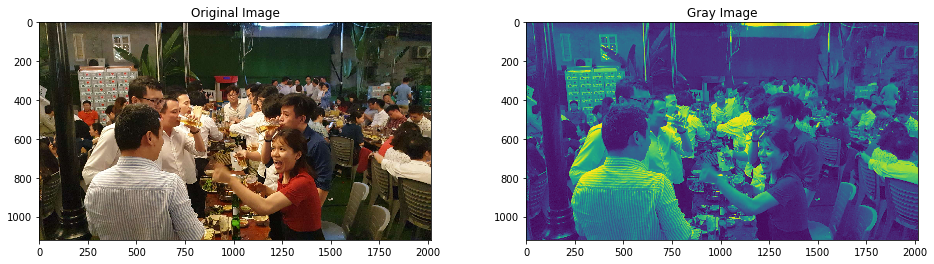

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = plt.imread('pic.JPEG', cv2.IMREAD_UNCHANGED)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print('image shape:', img.shape)
print('gray shape: ', gray.shape)

plt.figure(figsize = (16, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(gray)
plt.title('Gray Image')

In [11]:
# Calculate gradient gx, gy
gx = cv2.Sobel(gray, cv2.CV_32F, dx=0, dy=1, ksize=3)
gy = cv2.Sobel(gray, cv2.CV_32F, dx=1, dy=0, ksize=3)

In [12]:
print('gray shape: {}'.format(gray.shape))
print('gx shape: {}'.format(gx.shape))
print('gy shape: {}'.format(gy.shape))

gray shape: (1120, 2016)
gx shape: (1120, 2016)
gy shape: (1120, 2016)


In [13]:
g, theta = cv2.cartToPolar(gx, gy, angleInDegrees=True) 
print('gradient format: {}'.format(g.shape))
print('theta format: {}'.format(theta.shape))

gradient format: (1120, 2016)
theta format: (1120, 2016)


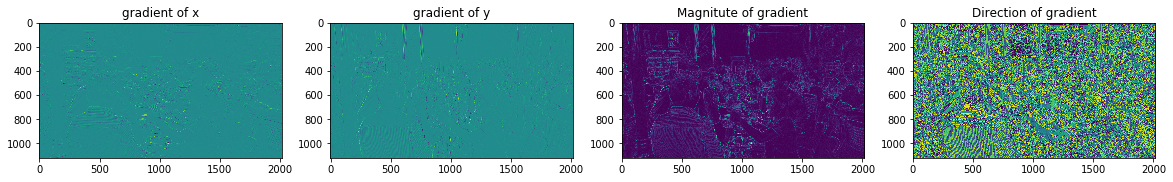

In [19]:
w = 20
h = 10

plt.figure(figsize=(w, h))
plt.subplot(1, 4, 1)
plt.title('gradient of x')
plt.imshow(gx)

plt.subplot(1, 4, 2)
plt.title('gradient of y')
plt.imshow(gy)

plt.subplot(1, 4, 3)
plt.title('Magnitute of gradient')
plt.imshow(g)

plt.subplot(1, 4, 4)
plt.title('Direction of gradient')
plt.imshow(theta)

### 2.1.2. Các bước tính HOG

Ta nhận thấy đặc trưng của mỗi bức ảnh được biểu diễn thông qua 2 thông số đó là mức độ thay đổi cường độ màu sắc thể hiện thông qua độ lớn gradient (`gradient magnitude`) và hướng thay đổi cường độ màu sắc thể hiện thông qua phương gradient (`gradient direction`). Do đó chúng ta cần tạo ra được một *bộ mô tả* (`feature descriptor`) sao cho biến đổi bức ảnh thành một véc tơ mà thể hiện được cả 2 thông tin này.

Để làm được như vậy, chúng ta chia hình ảnh thành một lưới ô vuông mà mỗi một ô có kích thước `8x8`. Như vậy chúng ta có tổng cộng 64 ô tương ứng với mỗi tọa độ. Trên mỗi một ô trong 64 ô chúng ta sẽ cần tính ra 2 tham số đó là độ lớn gradient (gradient magnitute) và phương gradient (gradient direction). Chúng ta sẽ có tổng cộng `8x8x2 = 128` giá trị cần tính bao gồm 64 giá trị gradient magnitute và 64 giá trị gradient direction như ma trận hình bên dưới:

![](https://www.learnopencv.com/wp-content/uploads/2016/12/hog-cell-gradients-768x432.png)

> **Hình 1:** Hình ảnh vận động viên được chia thành các lưới ô vuông, mỗi ô vuông có kích thước `8x8`. Trên mỗi ô chúng ta thực hiện tính đạo hàm thông qua bộ lọc Sobel để thu được 2 ma trận bên phải là gradient magnitude và gradient direction. 

Véc tơ histogram sẽ được tạo ra như sau:

**Bước 1:** Mapping độ lớn gradient vào các bins của phương gradient.

Sắp xếp các giá trị phương gradient theo thứ tự từ nhỏ đến lớn và chia chúng vào 9 bins. Độ lớn của phương gradient sẽ nằm trong khoảng [0, 180] nên mỗi bins sẽ có độ dài là 20 như hình bên dưới.


![](bins.jpg)


Mỗi một phương gradient trên ma trận gradient direction sẽ đi theo cặp với một độ lớn gradient ở cùng tọa độ với nó trên ma trận gradient magnitute. Khi biết được phương gradient thuộc bins nào trong véc tơ bins, ta sẽ điền vào giá trị giá trị của độ lớn gradient vào bin tương ứng.

Chẳng hạn trong hình bên dưới ta có ô bao bởi hình tròn viền xanh tương ứng với phương gradient bằng 80 và độ lớn gradient bằng 2. Khi đó tại véc tơ bins của Histogram of Gradients, phương gradient bằng 80 sẽ rơi vào vị trí thứ 5 nên tại ô này chúng ta điền giá trị độ lớn của gradient. 

![](https://www.learnopencv.com/wp-content/uploads/2016/12/hog-histogram-1.png)

> **Hình 2:** Mapping độ lớn gradients với các bins.

Trong trường hợp phương gradients không rơi vào các đầu mút (chẳng hạn 0, 20, 40,... là những số chia hết cho 20). Ta sẽ sử dụng linear interpolation để phân chia độ lớn gradient về 2 bins liền kề mà giá trị phương gradient thuộc về. Ví dụ: giá trị phương gradient bằng $x$ tương ứng với độ lớn gradient bằng $y$. Phương gradients rơi vào khoảng giữa bin thứ $(l-1)$ và bin thứ $l$: $x \in [x_0, x_1]$.  Khi đó giá trị tại 2 bins $(l-1)$ và $l$ được điền vào cường độ theo công thức interpolation:

* Gía trị tại bins $l-1$:
$$x_{l-1} = \frac{(x_1-x)}{x_1-x_0}*y$$
* Gía trị tại bins $l$:
$$x_{l} = \frac{(x-x_0)}{x_1-x_0}*y$$

![](https://www.learnopencv.com/wp-content/uploads/2016/12/hog-histogram-2.png)

> **Hình 3:**: Ví dụ với điểm được khoanh tròn bởi hình tròn màu xanh có phương gradient bằng 165 và độ lớn gradient bằng 85. Ta phân chia giá trị về các bins 0 (hoặc 180) và 160 các giá trị theo công thức interpolation bên trên. Kết quả cuối cùng chúng ta thu được là:

Tính tổng tất cả các độ lớn gradient thuộc cùng 1 bins của véc tơ bins ta thu được biểu đồ Histogram of Gradients như bên dưới:

![](https://www.learnopencv.com/wp-content/uploads/2016/12/histogram-8x8-cell.png)

> **Hình 4**: Biểu đồ Histogram of Gradient gồm 9 bins tương ứng với một ô vuông trong lưới ô vuông.


**Bước 2:** Chuẩn hóa véc tơ histogram theo block 16x16

Chúng ta thấy rằng véc tơ histogram sẽ bị phụ thuộc vào cường độ các pixcel của một bức ảnh. Với 2 bức ảnh có cùng nội dung nhưng bức ảnh biến thể tối hơn do được tạo thành từ bức ảnh gốc chia các cường độ pixcel cho 2. Khi đó giá trị các phần tử của véc tơ histogram của bức ảnh gốc cũng sẽ gấp đôi véc tơ histogram của bức ảnh biến thể. Chính vì thế ta cần chuẩn hóa véc tơ histogram để cả 2 bức ảnh có cùng một biểu diễn véc tơ như nhau.

Phép chuẩn hóa theo norm chuẩn bậc 2 được thực hiện để đưa 2 véc tơ histogram về cùng giá trị như sau:
$$\text{normalize}(\mathbf{h}) = \frac{\mathbf{h}}{||\mathbf{h}||_{2}}$$

Hoặc ngoài ra ta cũng có thể sử dụng norm chuẩn bậc 1.

Trong đó $\mathbf{h}$ là véc tơ histogram của các gradient. Xem thêm [Lý thuyết về norm chuẩn](https://www.kaggle.com/phamdinhkhanh/ml-appendix).

Qúa trình chuẩn hóa sẽ thực hiện trên một block kích thước `2x2` trên lưới ô vuông ban đầu (mỗi ô kích thước `8x8`). Như vậy chúng ta sẽ có 4 véc tơ histogram kích thước `1x9`, concatenate các véc tơ sẽ thu được véc tơ histogram tổng hợp kích thước là `1x36` và sau đó chuẩn hóa theo norm chuẩn bậc 2 trên véc tơ này. Việc di chuyển các window thực hiện tương tự như convolutional neural network 2D với các step 8 pixels như hình ảnh bên dưới:
![](https://www.learnopencv.com/wp-content/uploads/2016/12/hog-16x16-block-normalization.gif)

> **Hình 5:** Hình ảnh được phân chia thành lưới các ô vuông con, mỗi ô kích thước `8x8`. Thực hiện chuẩn hóa véc tơ histogram trên các block gồm `2x2` ô ứng với kích thước `16x16` pixcel.

**Bước 3:** Tính toán HOG feature véc tơ.

Sau khi chuẩn hóa các véc tơ histogram, chúng ta sẽ concatenate các véc tơ `1x36` này thành một véc tơ lớn. Đây chính là véc tơ HOG đại diện cho toàn bộ hình ảnh.

Ví dụ: Hình ảnh của chúng ta được chia thành lưới ô vuông kích thước `16x8` (mỗi ô `8x8`). Qúa trình tính toán HOG sẽ di chuyển 7 lượt theo chiều rộng và 15 lượt theo chiều cao. Như vậy sẽ có tổng cộng `7x15=105` patches, mỗi patch tương ứng với 1 véc tơ histograms 36 chiều. Do đó cuối cùng véc tơ HOG sẽ có kích thước là `105x36=3780` chiều. Đây là một véc tơ kích thước tương đối lớn nên có thể mô phỏng được đặc trưng của ảnh khá tốt.

**Biểu diễn phân phối HOG trên ảnh**

Đối với mỗi một ô trên lưới ô vuông, chúng ta biểu diễn phân phối HOG bao gồm nhóm 9 véc tơ chung gốc chiều dài bằng độ lớn gradient và góc bằng phương gradient. Khi đó chiều của nhóm các véc tơ sẽ tương đối gần với chiều của vận động viên trong ảnh, đặc biệt là tại các vị trí chân và tay. Cụ thể hãy xem hình bên dưới:

![](https://www.learnopencv.com/wp-content/uploads/2016/12/hog-visualization.png)

> **Hình 6:** Biểu diễn nhóm véc tơ histogram trên các lưới ô vuông của hình ảnh gốc. Các phương véc tơ phổ biến là chiều dọc trùng với chiều bức ảnh.

Điều này chứng tỏ bộ mô tả HOG đã mã hóa được các đặc trưng của một bức ảnh khá tốt.

# 3. Thực hành tính HOG

Như vậy qua mục 2 các bạn đã nắm vững được phương pháp tính HOG và ý nghĩa của thuật toán này trong việc tạo ra một mô tả đặc trưng cho mỗi bức ảnh. Tại mục này chúng ta sẽ đi vào thực hành cho một bức ảnh cụ thể. Để tính toán véc tơ HOG, chúng ta có thể sử dụng cả 2 packages `skimage` hoặc `opencv`. Tôi sẽ giới thiệu đến các bạn cách sử dụng HOG trên 2 packages này.

**opencv**

Trước tiên chúng ta cần xác định trước các tham số sau để khởi tạo một bộ mô tả HOG.

* nbins: Số lượng bins trong biểu đồ histogram.
* cellSize: Kích thước của một ô (đơn vị pixels).
* winSize: Kích thước của cửa sổ (đơn vị pixels).
* blockSize: Kích thước của một block (đơn vị pixels) mà trên đó ta chuẩn hóa véc tơ histogram tổng hợp.
* winStride: Số bước stride (đơn vị pixels) khi di chuyển window trên ảnh gốc để tính véc tơ histogram trên mỗi block của ảnh.

In [49]:
print('Kích thước ảnh gốc: ', img.shape)

# 1. Khai báo các tham số
cell_size = (8, 8)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins

# 2. Tính toán các tham số truyền vào HOGDescriptor
# winSize: Kích thước của bức ảnh được crop để chia hết cho cell size.
winSize = (img.shape[1] // cell_size[1] * cell_size[1], img.shape[0] // cell_size[0] * cell_size[0])
# blockSize: Kích thước của 1 block
blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
# blockStride: Số bước di chuyển của block khi thực hiện chuẩn hóa histogram bước 3
blockStride = (cell_size[1], cell_size[0])
print('Kích thước bức ảnh crop theo winSize (pixel): ', winSize)
print('Kích thước của 1 block (pixel): ', blockSize)
print('Kích thước của block stride (pixel): ', blockStride)

# 3. Compute HOG descriptor
hog = cv2.HOGDescriptor(_winSize=winSize,
                        _blockSize=blockSize,
                        _blockStride=blockStride,
                        _cellSize=cell_size,
                        _nbins=nbins)

# Kích thước của lưới ô vuông.
n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
print('Kích thước lưới ô vuông (ô vuông): ', n_cells)

# Reshape hog feature
hog_feats = hog.compute(img)\
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  

print('Kích thước hog feature (h, w, block_size_h, block_size_w, nbins): ', hog_feats.shape)

Kích thước ảnh gốc:  (1120, 2016, 3)
Kích thước bức ảnh crop theo winSize (pixel):  (2016, 1120)
Kích thước của 1 block (pixel):  (16, 16)
Kích thước của block stride (pixel):  (8, 8)
Kích thước lưới ô vuông (ô vuông):  (140, 252)
Kích thước hog feature (h, w, block_size_h, block_size_w, nbins):  (139, 251, 2, 2, 9)


Với đầu vào là một bức ảnh kích thước `1120 x 2016`, nếu áp dụng thuật toán tính HOG với kích thước cells là `8x8` chúng ta sẽ thu được một lưới ô vuông với kích thước là `1120/8 = 140` ô theo chiều cao và `2016/8 = 252` ô theo chiều rộng. Tiếp tục khởi tạo các block kích thước `2x2` ô với stride là `8x8` pixels ta sẽ trải qua 139 bước theo chiều cao và 251 bước theo chiều rộng. Trên mỗi block ta có 4 véc tơ histogram tương ứng với mỗi ô, mỗi véc tơ gồm 9 chiều tương ứng với 9 bins. Như vậy véc tơ HOG tổng hợp của bức ảnh sẽ có kích thước là `139 x 251 x 2 x 2 x 9 = 1256004` chiều.

**skimage**

Trên sklearn chúng ta xây dựng một bộ mô tả HOG như sau:

In [58]:
from skimage import feature
H = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2")

print('Kích thước hog features: ', H.shape)

Kích thước hog features:  (1256004,)


Trong đó các tham số quan trọng gồm:
* orientations: Số bins phân chia của phương gradient trong biểu đồ histogram.
* pixels_per_cell: Kích thước của một cell (đơn vị pixels).
* cells_per_block: Kích thước của một block (đơn vị cells). 
* block_norm: Phương pháp chuẩn hóa block

Ngoài ra trong skimage chúng ta còn cho phép biểu diễn hình ảnh của phân phối HOG trên bức ảnh như sau:

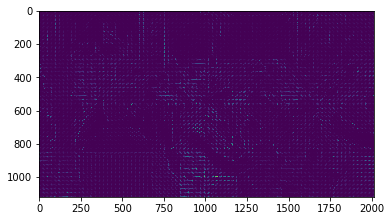

In [61]:
from skimage import exposure
from skimage import feature
import cv2
import matplotlib.pyplot as plt
 
(H, hogImage) = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2",
    visualize=True)

hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
hogImage = hogImage.astype("uint8")
 
plt.imshow(hogImage)

Do hogImage là một véc tơ có kích thước rất lớn (gần 1.2 triệu chiều) nên để giảm nhẹ kích thước lưu trữ khi xử lý với các bộ dữ liệu ảnh lớn, chúng ta nên convert giá trị của HOG sang data type `int8`. Mẹo nhỏ này giúp giảm thiểu khá nhiều tài nguyên lưu trữ tính toán.

# 4. Ứng dụng của HOG
## 4.1. Ứng dụng trong nhận diện người

Có khá nhiều các thuật toán từ hiện đại đến cổ điển giúp chúng ta phát hiện và nhận diện vật thể trong hình ảnh. Các bạn có thể xem lại [Bài 12 - Tổng hợp các phương pháp object detection](https://phamdinhkhanh.github.io/2019/09/29/OverviewObjectDetection.html) và [Bài 13 - Thuật toán SSD](https://phamdinhkhanh.github.io/2019/10/05/SSDModelObjectDetection.html) tại cùng blog này để tìm hiểu thêm về một số thuật toán như  vậy. 

Ngoài ra, để phát hiện người trong các hình ảnh tĩnh hoặc thậm chí video chúng ta có thể sử dụng mô hình pretrained - SVM dự báo dựa trên đầu vào là đặc trưng của ảnh được trích xuất từ thuật toán HOG. Các mô hình đã được tích hợp sẵn vào opencv nên khá đơn giản để áp dụng.

In [4]:
from __future__ import print_function
from imutils.object_detection import non_max_suppression
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2

 
# Khởi tạo một bộ mô tả đặc trưng HOG
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

hàm `HOGDescriptor()` sẽ khởi tạo một bộ mô tả đặc trưng theo thuật toán HOG. Sau đó chúng ta áp dụng hàm `setSVMDetector()` để thiết lập mô hình pretrained dựa trên thuật toán SVM. Cuối cùng ta thu được một mô hình phát hiện người trên các bức ảnh. Việc load thuật toán thật đơn giản phải không các bạn? Để xem hiệu quả của thuật toán ra sao chúng ta cùng thử dự báo trên folder gồm các ảnh chứa người nhé.

weights:  [[2.71816366]
 [0.52841349]]
rects:  (2, 4)
[INFO] person_010.bmp: 2 original boxes, 2 after suppression
weights:  [[3.768822]]
rects:  (1, 4)
[INFO] person_011.bmp: 1 original boxes, 1 after suppression
weights:  [[2.77929745]
 [3.59028377]]
rects:  (2, 4)
[INFO] person_014.bmp: 2 original boxes, 2 after suppression
weights:  [[0.29745264]
 [0.30366847]
 [0.47773247]
 [0.27683734]]
rects:  (4, 4)
[INFO] person_029.bmp: 4 original boxes, 1 after suppression
weights:  [[0.39238931]
 [0.92878312]
 [0.67034378]]
rects:  (3, 4)
[INFO] person_032.bmp: 3 original boxes, 1 after suppression
weights:  [[0.51366272]
 [0.16095307]]
rects:  (2, 4)
[INFO] person_033.bmp: 2 original boxes, 1 after suppression
weights:  [[3.47940904]
 [1.68886039]]
rects:  (2, 4)
[INFO] person_044.bmp: 2 original boxes, 2 after suppression


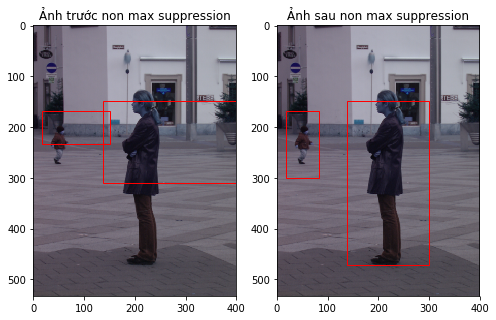

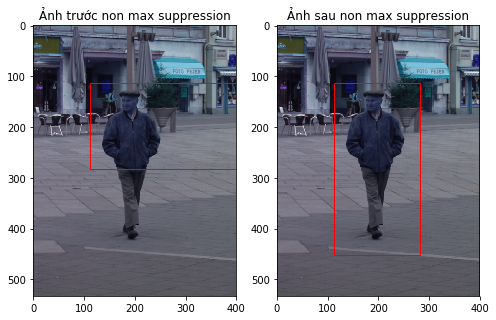

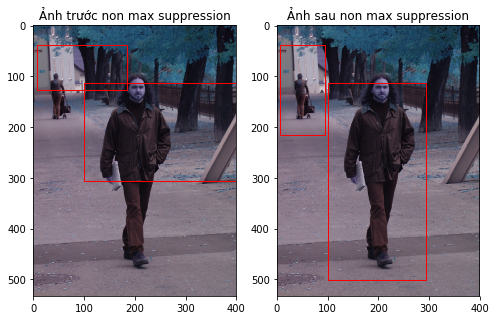

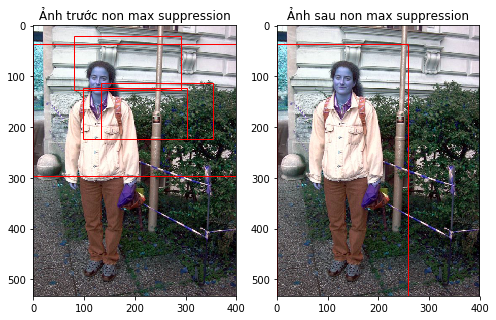

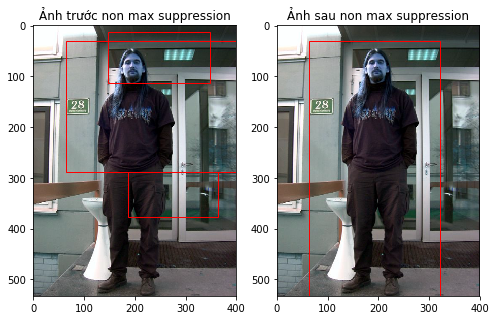

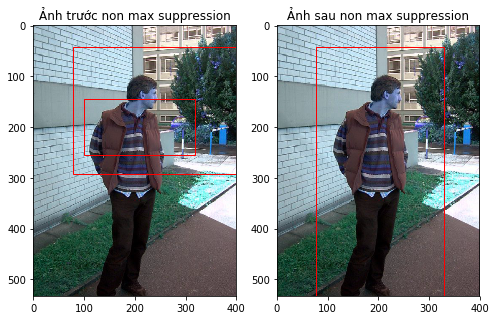

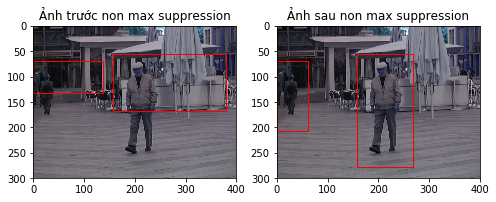

In [17]:
import glob
import matplotlib.patches as patches
import cv2
import imutils
import matplotlib.pyplot as plt

for i, imagePath in enumerate(glob.glob('images/*.bmp')):
    if i <= 6:
        image = cv2.imread(imagePath)
        image = imutils.resize(image, width = min(400, image.shape[1]))
        orig = image.copy()
        
        plt.figure(figsize = (8, 6))
        # 1. Bounding box với ảnh gốc
        # Khởi tạo plot
        ax1 = plt.subplot(1, 2, 1)
        
        # Phát hiện người trong ảnh
        (rects, weights) = hog.detectMultiScale(img = image, winStride = (4, 4),
                                               padding = (8, 8), scale = 1.05)
        print('weights: ', weights)
        # Vẽ các bounding box xung quanh ảnh gốc
        for (x, y, h, w) in rects:
            # cv2.rectangle(orig, (x, y), (x+w, y+h), (0, 0, 255), 2)
            rectFig = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
            ax1.imshow(orig)
            ax1.add_patch(rectFig)
            plt.title('Ảnh trước non max suppression')

        rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
        print('rects: ', rects.shape)
        # Sử dụng non max suppression để lấy ra bounding box cuối cùng với ngưỡng threshold = 0.65
        pick = non_max_suppression(rects, probs = None, overlapThresh=0.65)
        
        # 2. Bounding box với ảnh suppression
        # Khởi tạo plot
        ax2 = plt.subplot(1, 2, 2)
        # Vẽ bounding box cuối cùng trên ảnh
        for (xA, yA, xB, yB) in pick:
            w = xB-xA
            h = yB-yA
            # cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)
            # Hiển thị hình ảnh
            plt.imshow(image)
            plt.title('Ảnh sau non max suppression')
            rectFig = patches.Rectangle((xA, yA),w,h,linewidth=1,edgecolor='r',facecolor='none')
            ax2.add_patch(rectFig)
            
        # Lấy thông tin ảnh
        filename = imagePath[imagePath.rfind("\\") + 1:]
        print("[INFO] {}: {} original boxes, {} after suppression".format(
            filename, len(rects), len(pick)))

        # cv2.imshow("Before NMS", orig)
        # cv2.imshow("After NMS", image)
        # cv2.waitKey(0)

Trong code trên hàm số quan trọng nhất đó là `hog.detectMultiScale()` nhằm phát hiện vật thể là người trong ảnh.
Chúng ta cần truyền vào hàm này các tham số:
* img: Ma trận cường độ màu sắc của bức ảnh.
* winStride: Để phát hiện vật thể thì chúng ta cần di chuyển một window lên toàn bộ các phần của ảnh theo chiều từ trái sang phải và trên xuống dưới. winStride sẽ qui định kích thước của vùng ảnh nhận diện. `winStride` và `scale` là những tham số cực kì quan trọng và cần được thiết lập chính xác để giúp nhận diện được vật thể chứa trong nó.
* padding: Là một tuple gồm các tham số thể hiện số lượng pixels được thêm vào theo cả 2 chiều $x$ và $y$ của sliding window ROI trước khi thực hiện trích lọc đặc trưng HOG.
* scale: Hệ số tăng kích thước của ảnh gốc. Gỉa sử bức ảnh của chúng ta được scale thành các layers khác nhau như hình kim tự tháp bên dưới. 
![](https://www.pyimagesearch.com/wp-content/uploads/2015/03/pyramid_example.png)
Khi đó mỗi layer trên kim tự tháp là 1 bức ảnh được tạo thành từ bức ảnh gốc zoom nhỏ kích thước theo scale. Nếu tham số scale càng lớn thì số lượng layer của ảnh càng nhỏ và chúng ta thu được càng nhiều bounding box hơn. Thông thường giá trị scale được thiết lập một giá trị lớn hơn 1 và gần bằng 1 (chẳng hạn 1.01 hoặc 1.05).

Ngoài ra để giảm thiểu có quá nhiều khung hình bao quanh vật thể, chúng ta sử dụng phương pháp `non max suppression` thông qua hàm `non_max_suppression()`. Tôi sẽ không đi sâu lý thuyết về phương pháp này. Đại khái dựa trên tỷ lệ phần diện tích giao nhau IoU (Intersection of Union) giữa các bounding box lớn hơn một ngưỡng nào đó để giữa lại một bounding box có xác suất chứa vật thể lớn hơn. Lặp lại quá trình này, từ $n$ bounding box giao nhau ta thu được một final bounding box. Đây là phương pháp được ứng dụng trong hầu hết các thuật toán object detection từ cổ điển cho tới hiện đại.

Một số kết quả thu được sau khi áp dụng HOG cho thấy thuật toán hoạt động khá tốt trong việc nhận diện ảnh người khi nhận biết được nhiều người trên cùng 1 bức ảnh và với kích thước to nhỏ khác nhau.

## 4.2. Ứng dụng trong feature engineering
Trước đây, trước khi mạng CNN bùng nổ và trở nên phổ biến. HOG cùng với SHIFT được biết đến như một phương pháp chủ yếu để mô tả đặc trưng của hình ảnh. Ngày nay HOG không còn dược sử dụng nhiều nữa. Tuy nhiên, đối với các bộ dữ liệu kích thước nhỏ, HOG có thể được sử dụng để tạo đặc trưng đầu vào cho các thuật toán học có giám sát cổ điển như `kNN, SVM, Logistic Regression, Decision Tree` mà vẫn mang lại độ chính xác cao, quá trình huấn luyện nhanh và yêu cầu ít tài nguyên tính toán. Nếu sử dụng các mạng CNN các bạn có thể sẽ cần phải tạo ra những mạng nơ ron lên tới hàng triệu tham số tính toán mà độ chính xác chỉ ngang bằng hoặc kém hơn và rất lãng phí tài nguyên.

Bên dưới chúng ta cùng thực hành xây dựng mộ mô hình phân loại nhãn hiệu xe dựa trên ảnh logo thông qua việc trích suất đặc trưng HOG. Dữ liệu gồm trên bức ảnh logo của 10 thương hiệu xe được chia làm 2 tập train và test. Tập train gồm 1000 ảnh với 100 ảnh/mỗi thương hiệu và tập test gồm 500 ảnh với 50 ảnh/mỗi thương hiệu. Để tiện cho thực hành, bạn đọc có thể download dữ liệu tại [carLogo](https://drive.google.com/file/d/1w99mnx37gnMSu0YHKnyhDIs4masNiDML/view?usp=sharing).

**Bước 1:** Tạo feature descriptor dựa trên thuật toán HOG.

Đầu tiên chúng ta cần tạo ra véc tơ HOG cho mỗi hình ảnh để làm đầu vào huấn luyện.

In [124]:
import os
import glob
import imutils

def _preprocessing(fileType):
    data = []
    labels = []
    for path in glob.glob(fileType):
        _, brand, fn = path.split('\\')
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edeged = imutils.auto_canny(gray)

        # Tìm contours trong edge map, chỉ giữ lại contours lớn nhất, được giả định là chứa logo xe.
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key = cv2.contourArea)

        # Trích xuất logo của xe và resize lại kích thước ảnh logo về 200x200
        (x, y, w, h) = cv2.boundingRect(c)
        logo = gray[y:y+h, x:x+w]
        logo = cv2.resize(logo, (200, 200))

        # Khởi tạo HOG descriptor
        H = feature.hog(logo, orientations=9, pixels_per_cell=(10, 10),
            cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

        # update the data and labels
        data.append(H)
        labels.append(brand)
    return data, labels

data, labels = _preprocessing('trainData/**/*.jpg')

In [126]:
import pickle

def _save(path, obj):
    with open(path, 'wb') as fn:
        pickle.dump(obj, fn)
        
# _save('X_train.pkl', data)
# _save('y_train.pkl', labels)

In [132]:
# _save('X_test.pkl', dataTest)
# _save('y_test.pkl', labelsTest)

In [152]:
from sklearn.preprocessing import LabelEncoder

def _transform_data(data, labels):
    # Tạo input array X
    X = np.array(data)
    # Tạo output array y
    le = LabelEncoder()
    le.fit(labels)
    y = le.transform(labels)
    y_ind = np.unique(y)
    y_dict = dict(zip(y_ind, le.classes_))
    return X, y, y_dict, le

X_train, y_train, y_dict, le = _transform_data(data, labels) 

Xây dựng thuật toán kNN với số lượng các điểm lân cận $k = 1$.

In [186]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [187]:
y_pred = model.predict(X_train)

In [188]:
# Kiểm tra độ chính xác của mô hình trên train
from sklearn.metrics import classification_report
uniq_labels = list(y_dict.values())
print(classification_report(y_train, y_pred, target_names = uniq_labels))

              precision    recall  f1-score   support

       Buick       1.00      1.00      1.00       100
       Chery       1.00      1.00      1.00       100
     Citroen       1.00      1.00      1.00       100
       Honda       1.00      1.00      1.00       100
     Hyundai       1.00      1.00      1.00       100
       Lexus       1.00      1.00      1.00       100
       Mazda       1.00      1.00      1.00       100
     Peugeot       1.00      1.00      1.00       100
      Toyota       1.00      1.00      1.00       100
          VW       1.00      1.00      1.00       100

   micro avg       1.00      1.00      1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [189]:
# Kiểm tra độ chính xác trên tập test
dataTest, labelsTest = _preprocessing('TestData/**/*.jpg')
X_test, y_test, y_dict, le = _transform_data(dataTest, labelsTest) 

In [190]:
y_predTest = model.predict(X_test)

In [191]:
# Kiểm tra độ chính xác của mô hình trên train
from sklearn.metrics import classification_report
uniq_labels = list(y_dict.values())
print(classification_report(y_test, y_predTest, target_names = uniq_labels))

              precision    recall  f1-score   support

       Buick       0.93      0.80      0.86        50
       Chery       0.81      0.96      0.88        50
     Citroen       1.00      0.90      0.95        50
       Honda       1.00      0.82      0.90        50
     Hyundai       0.72      0.72      0.72        50
       Lexus       0.60      0.90      0.72        50
       Mazda       0.64      1.00      0.78        50
     Peugeot       1.00      0.76      0.86        50
      Toyota       0.89      0.64      0.74        50
          VW       0.97      0.68      0.80        50

   micro avg       0.82      0.82      0.82       500
   macro avg       0.86      0.82      0.82       500
weighted avg       0.86      0.82      0.82       500



Xây dựng model với mạng CNN

In [3]:
import os
from PIL import Image
import numpy as np
# loading all images
path = "TrainData/"
imgs = []
labels= []
brands = os.listdir(path)
print(brands)
for idcar, brand in enumerate(brands):
    img = os.listdir(path+brand)
    for i, value in enumerate(img):
        imgs.append(value)
        labels.append(idcar)
images = np.array([np.array(Image.open(path+brands[labels[i]]+'/'+value).convert("RGB") ).flatten() for i, value in enumerate(imgs)], order='F', dtype='uint8')
# Mỗi ảnh có kích thước 70x70 = 2500 pixel và 3 kênh màu = 14700 pixel
print('total images: ', images.shape)

['Buick', 'Chery', 'Citroen', 'Honda', 'Hyundai', 'Lexus', 'Mazda', 'Peugeot', 'Toyota', 'VW']
total images:  (1000, 14700)


In [6]:
# reshape anh ngược trở về kích thước 70x70x3
img_x = img_y = 70

def ImageConvert(n, i):
    im_ex = i.reshape(n, img_x, img_y, 3)
    im_ex = im_ex.astype('float32') / 255
    # Chuẩn hóa cường độ ảnh về khoảng (-1, 1)
    im_ex = np.subtract(im_ex, 0.5)
    im_ex = np.multiply(im_ex, 2.0)
    return im_ex

X_train = ImageConvert(images.shape[0], images)

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)
y_train = le.transform(labels)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal, VarianceScaling

def contruction(n_channels):
    model = Sequential()
    model.add(Conv2D(32, (3,3),
                     input_shape=(img_x,img_y,n_channels),
                     padding='valid',
                     bias_initializer='glorot_uniform',
                     kernel_regularizer=l2(0.00004),
                     kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, (3,3),
                     padding='valid',
                     bias_initializer='glorot_uniform',
                     kernel_regularizer=l2(0.00004),
                     kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128, (3,3),
                     padding='valid',
                     bias_initializer='glorot_uniform',
                     kernel_regularizer=l2(0.00004),
                     kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(256, (3,3),
                     padding='valid',
                     bias_initializer='glorot_uniform',
                     kernel_regularizer=l2(0.00004),
                     kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    
    model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    
    # final activation is softmax, tuned to the number of classes/labels possible
    model.add(Dense(len(brands), activation='softmax'))
    
    # optimizer will be a stochastic gradient descent, learning rate set at 0.005
    sgd = SGD(lr=0.005, decay=1e-6, momentum=0.95, nesterov=True)
    adam = Adam()
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])
    return model

model = contruction(3)
# Let's look at the summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 5, 256)        

In [22]:
n_epochs = 100
batch = 128
early_stopping = EarlyStopping(patience=4, monitor='val_loss')
CNN_file = '10car_1CNN_CMCMCMCMF.h5py'
take_best_model = ModelCheckpoint(CNN_file, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=batch, shuffle=True, 
                    epochs=n_epochs, verbose=1, validation_split=0.2, 
                    callbacks=[early_stopping, take_best_model])

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 5s 6ms/sample - loss: 2.6464 - categorical_accuracy: 0.1025 - val_loss: 4.8430 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
800/800 [==============================] - 5s 6ms/sample - loss: 2.0414 - categorical_accuracy: 0.0650 - val_loss: 4.7925 - val_categorical_accuracy: 0.2100
Epoch 3/100
800/800 [==============================] - 3s 4ms/sample - loss: 1.9496 - categorical_accuracy: 0.0838 - val_loss: 6.0227 - val_categorical_accuracy: 0.0000e+00
Epoch 4/100
800/800 [==============================] - 3s 4ms/sample - loss: 1.7672 - categorical_accuracy: 0.0575 - val_loss: 8.2672 - val_categorical_accuracy: 0.0350
Epoch 5/100
800/800 [==============================] - 3s 4ms/sample - loss: 1.5432 - categorical_accuracy: 0.0787 - val_loss: 10.7318 - val_categorical_accuracy: 0.0350
Epoch 6/100
800/800 [==============================] - 3s 4ms/sample - loss: 1.2267 - categorical_ac

Vẽ biểu đồ accuracy và loss

(0, 1)

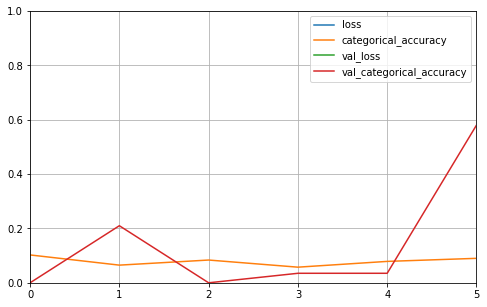

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

Ta thấy rằng với tập dữ liệu nhỏ như vậy thì thuật toán CNN tỏ ra kém hiệu quả. Accuracy đạt được trên validation thậm chí dưới 60%. Điều này có thể là do dữ liệu của chúng ta quá nhỏ nên CNN không thể học được tính chất tổng quát của những bộ dữ liệu như vậy. Trong trường hợp này sử dụng bộ mô tả HOG kết hợp với những thuật toán đơn giản lại mang lại kết quả bất ngờ.

# 5. Tổng kết

Trong xử lý ảnh, thuật toán HOG làm một trong những bộ mô tả đặc trưng mạnh giúp mã hóa hình ảnh thành một véc tơ đặc trưng với số chiều đủ lớn để có thể phân loại tốt các bức ảnh. Nguyên lý hoạt động của thuật toán là dựa trên biểu diễn véc tơ histogram của độ lớn gradient theo các bins của phương gradient áp dụng trên những vùng ảnh cụ bộ. Các phương pháp chuẩn hóa được áp dụng giúp véc tơ histogram tổng hợp trở nên bất biến với sự thay đổi về cường độ màu sắc của các bức ảnh có cùng nội dung nhưng khác nhau về cường độ màu sắc.

Trong object detection, thuật toán tỏ ra khá hiệu quả khi ứng dụng tốt để phát hiện người với nhiều kích thước khác nhau. Đồng thời trong một số trường hợp phân loại ảnh, khi bộ dữ liệu có kích thước nhỏ thì những mạng nơ ron lớn như CNN có thể hoạt động không chính xác do tập ảnh huấn luyện không đủ bao quát các khả năng. Khi đó việc áp dụng những phương pháp cổ điển để trích lọc đặc trưng như HOG lại mang lại những kết quả bất ngờ mà tốt ít tài nguyên và chi phí tính toán.

Qua đó chúng ta thấy được HOG mặc dù là phương pháp cũ nhưng vẫn rất hiệu quả trong nhiều bài toán. Tùy từng tình huống mà chúng ta có thể sử dụng thuật toán HOG chứ không nhất thiết phải áp dụng một mô hình deep learning với hàng triệu tham số thì mới mang lại độ chính xác cao.

# 6. Tài liệu

1. [Object Detection for Dummies Part 1: Gradient Vector, HOG, and SS - Lil'Log](https://lilianweng.github.io/lil-log/2017/10/29/object-recognition-for-dummies-part-1.html)
2. [Histograms of Oriented Gradients for Human Detection - Dalal, Trigg](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)
3. [Histogram of Oriented Gradients - Satya Mallick](https://www.learnopencv.com/histogram-of-oriented-gradients/)
4. [pedestrian detection opencv - pyimagesearch](https://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/)
5. [Tìm hiểu về hog(histogram of oriented gradients) - Nguyễn Phương Lan](https://viblo.asia/p/tim-hieu-ve-hoghistogram-of-oriented-gradients-m68Z0wL6KkG)
6. [Tìm hiểu về phương pháp mô tả đặc trưng HOG (Histogram of Oriented Gradients) - Hai Ha](https://viblo.asia/p/tim-hieu-ve-phuong-phap-mo-ta-dac-trung-hog-histogram-of-oriented-gradients-V3m5WAwxZO7)
7. [Trích đặc trưng HOG - Histograms of Oriented Gradients - Minh Nguyen](https://minhng.info/tutorials/histograms-of-oriented-gradients.html)
8. [Bài 12 - Các thuật toán Object Detection - Phạm Đình Khánh](https://phamdinhkhanh.github.io/2019/09/29/OverviewObjectDetection.html)
9. [Bài 13 - Model SSD trong Object Detection - Phạm Đình Khánh](https://phamdinhkhanh.github.io/2019/10/05/SSDModelObjectDetection.html)